In [41]:
from IPython.display import Audio, display
import wave 
import numpy as np
from scipy.signal import stft, istft #short time fourier transform, inverse STFT
from scipy.linalg import det 
from time import time
from scipy.io import wavfile
import matplotlib.pyplot as plt

In [2]:
file = "test2\\test2_female3_srec_130ms_4cm_mix.wav"

In [3]:
a = wave.open(file, mode = 'rb')

In [4]:
nchannels, sampwidth, framerate, nframes, comptype, compname = a.getparams()

print(f" number of channels = {nchannels},\n largeur de l'échantillon {sampwidth} octets,\n", 
      f"fréquence d'échantillonnage = {framerate},\n nombre de trames audio = {nframes},\n",
      f"type de compression = {comptype}")


 number of channels = 2,
 largeur de l'échantillon 2 octets,
 fréquence d'échantillonnage = 16000,
 nombre de trames audio = 163999,
 type de compression = NONE


In [5]:
a.rewind()
a.readframes(1)

b'\x00\x00\x00\x00'

In [6]:
rate, audio = wavfile.read(file)
##audio est une matrice n_channels*n_trames_audio

In [7]:
print(f"The frequency is {rate} Hz")

The frequency is 16000 Hz


In [8]:
Audio(file) #pour écouter un fichier

In [9]:
display(Audio(audio[:,0], rate=rate))
display(Audio(audio[:,1], rate=rate))

In [10]:
##On va prendre deux files, ce sont des enregistrements de voix qui se superposent.
##Les enregistrements sont en stéréo donc ont deux channels 
file1 = "test2\\test2_female4_srec_130ms_4cm_mix.wav"
file2 = "test2\\test2_female4_srec_380ms_4cm_mix.wav"

In [11]:
rate1, audio1 = wavfile.read(file1)
rate2, audio2 = wavfile.read(file2)
##avec 4 sources dispersés dans la pièces et 4 microphone à des places différentes, 
##on est censé pouvoir faire de la séparation de sources

In [12]:
##all micro are different vectors, ce sont les enregistrements x_i(t) dans l'article, 
##on veut retrouver les sources s_i(t) 
micro1 = audio1[:,0]
micro2 = audio1[:,1]
micro3 = audio2[:,0]
micro4 = audio2[:,1]

In [13]:
256*10/micro1.shape[0]

0.015609851279580972

In [14]:
f_arr,t_arr,Zxx = stft(micro1, fs = rate1)

In [15]:
print(len(f_arr), len(t_arr))
print(Zxx.shape) #Zxx[f,t]

129 1283
(129, 1283)


In [210]:
def G_etoile (y_jn, r_jn) -> float:
    "This function returns the majorization function"
    coeff = 1/(2*beta*np.sqrt(r_jn**2 + alpha) ) 
    
    norm_2 =  np.sum(abs(y_jn)**2, axis =0) 

    if norm_2.shape != ():
        raise TypeError( 'Wrong type for y_jn, it should be a vector')
        
    F = lambda r : np.sqrt(r**2+alpha)/beta - r**2/(2*beta*np.sqrt(r**2+alpha))   #F est à changer, on a regardé un article pour trouver ça 
    return coeff*norm_2 + F(r_jn) #premier terme de la somme ok
    

In [211]:
def G_etoile_ICA(y_jn, r_jn) -> float:
    "This function returns the majorization function"
    coeff = 1/(2*beta*np.sqrt(r_jn**2 + alpha) ) #taille I
    
    square_abs_y =  abs(y_jn)**2  #taille I

    if y_jn.shape != (y_jn.shape[0],):
        raise TypeError( 'Wrong type for y_jn, it should be a vector')
        
    F = lambda r : np.sqrt(r**2+alpha)/beta - r**2/(2*beta*np.sqrt(r**2+alpha))   #F est à changer, on a regardé un article pour trouver ça 
    return np.sum(coeff*square_abs_y + F(r_jn)) #premier terme de la somme ok

In [239]:
def C_etoile(W,R,method = 'IVA'):
    #W_i = W[i,:,:] # est une matrice de taille m*m, on selectionne la frequence i 
    #yjn = Y[:,j,n] #i la fréquence, j le temps, m le cannal, n le nombre de locuteurs, ici N=M donc meme indice n=m
    ##y = source estimates
    #r_jn = R[j,n] #def ainsi dans l'article, car doit correspondre a la norme de yjn
    
    I,J,N = Y.shape
    
    G_sum = 0
    for j in range(J):
        for n in range(N):
            if method=='IVA':
                G_sum+= G_etoile(Y[:,j,n], R[j,n])
            elif method =='ICA':
                G_sum+= G_etoile_ICA(Y[:,j,n], R[:,j,n])
            else:
                raise NotImplementedError("Implement your method for majoring function G_star.")
            
    sum_log_det=0
    
    for i in range(I):
        sum_log_det += np.log(abs(det(W[i,:,:]))) 
        
    return G_sum - 2*J*sum_log_det

In [213]:
def update(W,x):
    "Cet algo update les W en fonction de l'équation (59), (60) de l'article, x est le mélange"
    I,J,N = x.shape #nombres de bin fréquences, nombre d'indice temporelles, nombre channels
    
    #Mise à jour de la variable auxiliaire r##  
    y = np.einsum('inm,ijm->ijn', W, x, dtype = 'complex128')
    r = np.sqrt( np.sum(abs(y)**2, axis = 0)  )  #r_jn = ||y_jn||_2
    
    
    ##Mise à jour de la variable objective W##
    
    ##Calcul de U ##
    ##
    coefficients = 1/(2*beta*np.sqrt(r**2 + alpha) )
    U = np.einsum('jn,ijm,ijl->inml', coefficients, x, np.conj(x), dtype = 'complex128')
    U/=J
    

    ##Mise à jour de W##
    new_W = np.zeros((I,N,N),dtype='complex128')##new_W est la matrice empilé defini en (55)
    
    for n in range(N):
        for i in range(I):
        
            
            w_in = np.linalg.inv(W[i,:,:]@U[i,n,:,:]) [:,n]  
            #n ieme colone de l'inverse de W_i@U_in 
            
            w_in /= np.sqrt( np.conj(w_in.T) @ U[i,n,:,:]@w_in ) #vérifié
            
            new_W [i,n,:] = np.conj(w_in) #vérifié
            ##on change la ligne n par w_in^H
            
    return new_W , r #variables objectives et auxilières respectivement

In [214]:
def update_ICA(W,x):
    "Cet algo update les W en fonction de l'équation (59), (60) de l'article, x est le mélange. Mais les composantes de la STFT de x sont indépendants en fonction de la timeframe"
    I,J,N = x.shape #nombres de bin fréquences, nombre d'indice temporelles, nombre channels
    
    r = np.zeros((I,J,N))
    for n in range(N):
        #Mise à jour de la variable auxiliaire r##  
        yn = np.einsum('im,ijm->ij', W[:,n,:], x, dtype = 'complex128')
        rn = abs(yn)  #r_ijn = |y_ijn|
        
        r[:,:,n] = rn #le vecteur est ici de taille J

        ##Mise à jour de la variable objective W##

        ##Calcul de U ##
        ##
        coefficients = 1/(2*beta*np.sqrt(r**2 + alpha) ) #coef ij n car il y a r
        Un = np.einsum('ij,ijm,ijl->iml', coefficients[:,:,n], x, np.conj(x), dtype = 'complex128') #Un = (U_1n, ..., U_In)
        Un/=J


    ##Mise à jour de W##
    ##new_W est la matrice empilé defini en (55)
    
    
        for i in range(I):
        
            
            w_in = np.linalg.inv(W[i,:,:]@Un[i,:,:]) [:,n]  
            #n ieme colone de l'inverse de W_i@U_in 
            
            w_in /= np.sqrt( np.conj(w_in.T) @ Un[i,:,:]@w_in ) #vérifié
            
            W [i,n,:] = np.conj(w_in) #vérifié
            ##on change la ligne n par w_in^H
            
    return W,r  #variables objectives et auxilières respectivement

In [215]:
def update_IVA(W,x):
    "Cet algo update les W en fonction de l'équation (59), (60) de l'article, x est le mélange"
    I,J,N = x.shape #nombres de bin fréquences, nombre d'indice temporelles, nombre channels
    
    r = np.zeros((J,N))
    for n in range(N):
        #Mise à jour de la variable auxiliaire r##  
        yn = np.einsum('im,ijm->ij', W[:,n,:], x, dtype = 'complex128')
        rn = np.sqrt( np.sum(abs(yn)**2, axis = 0)  )  #r_jn = ||y_jn||_2
        
        r[:,n] = rn #le vecteur est ici de taille J

        ##Mise à jour de la variable objective W##

        ##Calcul de U ##
        ##
        coefficients = 1/(2*beta*np.sqrt(rn**2 + alpha) )
        Un = np.einsum('j,ijm,ijl->iml', coefficients, x, np.conj(x), dtype = 'complex128') #Un = (U_1n, ..., U_In)
        Un/=J


    ##Mise à jour de W##
    ##new_W est la matrice empilé defini en (55)
    
    
        for i in range(I):
        
            
            w_in = np.linalg.inv(W[i,:,:]@Un[i,:,:]) [:,n]  
            #n ieme colone de l'inverse de W_i@U_in 
            
            w_in /= np.sqrt( np.conj(w_in.T) @ Un[i,:,:]@w_in ) #vérifié
            
            W [i,n,:] = np.conj(w_in) #vérifié
            ##on change la ligne n par w_in^H
            
    return W,r  #variables objectives et auxilières respectivement

In [216]:
def update_tky823(W,X):
    "Cet algo update les W comme sur le github, c'est quasi un cc"
    
    n_sources, n_channels = X.shape[2], X.shape[2]
    n_bins = X.shape[0] #c'est I!
    eps, threshold = 1e-12 , 1e+22


    Y = np.einsum('inm,ijm->nij', W, X, dtype='complex128') #(n=sources,i=bins,j=frames)

    r = (np.sqrt( np.sum(abs(Y)**2, axis = 1)  )).transpose(1,0) #on somme sur les i, puis on inverse n et j #r_jn = ||y_jn||_2

    P = np.abs(Y)**2 # (n_sources, n_bins, n_frames)
    R = P.mean(axis=1) # (n_sources, n_frames)
    R = R[:, np.newaxis, :, np.newaxis, np.newaxis] # (n_sources, 1, n_frames, 1, 1)

    #X = X.transpose(1, 2, 0) # (n_bins, n_frames, n_channels)
    X = X[..., np.newaxis]
    X_Hermite = X.transpose(0, 1, 3, 2).conj()
    XX = X @ X_Hermite # (n_bins, n_frames, n_channels, n_channels)
    R[R < eps] = eps
    U = XX / R # (n_sources, n_bins, n_frames, n_channels, n_channels) il est où le G'(r)? meme chose en prenant alpha=0 et beta=1
    U = U.mean(axis=2) # (n_sources, n_bins, n_channels, n_channels)
    E = np.eye(n_sources, n_channels)
    E = np.tile(E, reps=(n_bins, 1, 1)) # (n_bins, n_sources, n_channels) #crée la base canonique de R^n

    for n in range(n_sources):
        # W: (n_bins, n_sources, n_channels), U: (n_sources, n_bins, n_channels, n_channels)
        w_n_Hermite = W[:, n, :] # (n_bins, n_channels)
        U_n = U[n] # (n_bins, n_channels, n_channels)
        WU = W @ U_n # (n_bins, n_sources, n_channels)
        condition = np.linalg.cond(WU) < threshold # (n_bins,)
        condition = condition[:, np.newaxis] # (n_bins, 1)
        e_n = E[:, n, :]
        w_n = np.linalg.solve(WU, e_n)
        wUw = w_n[:, np.newaxis, :].conj() @ U_n @ w_n[:, :, np.newaxis]
        denominator = np.sqrt(wUw[..., 0])
        w_n_Hermite = np.where(condition, w_n.conj() / denominator, w_n_Hermite)
        # if condition number is too big, `denominator[denominator < eps] = eps` may occur divergence of cost function.
        W[:, n, :] = w_n_Hermite

    return W,r

        #X = self.input
        #fais la mêem chose que mon magnifique np.einsum, Y = self.separate(X, demix_filter=W)
        
        #self.estimation = Y

In [217]:
def diviseur_proche(a, b):
    diviseurs = []
    # Trouver tous les diviseurs de b
    for i in range(1, b+1):
        if b % i == 0:
            diviseurs.append(i)
    # Trouver le diviseur le plus proche de a
    diviseur_proche = min(diviseurs, key=lambda x: abs(x-a))
    return diviseur_proche

In [218]:
##Parametre de la STFT
## frame width and shift of the STFT were 256 ms and 64 ms, respectively
frame_width = 0.256 #seconds
shift = 0.064 #seconds
duree = micro1.shape[0]
frame_width_indice = int(frame_width*duree/10) #le signal dure 10 secondes, on fait un produit en croix pour avoir le nombres d'incidices correspondants.
noverlap = frame_width_indice - int(shift*duree/10) #si le shift est de theta, alors l'overlap est de max(0,1-theta) 

In [246]:
### Short time Fourier Transform of microphones

f_arr,t_arr,Zxx1 = stft( micro1, fs = rate1, nperseg = frame_width_indice, noverlap = noverlap )
f_arr,t_arr,Zxx2 = stft( micro2, fs = rate1, nperseg = frame_width_indice, noverlap = noverlap )
f_arr,t_arr,Zxx3 = stft( micro3, fs = rate1, nperseg = frame_width_indice, noverlap = noverlap )
f_arr,t_arr,Zxx4 = stft( micro4, fs = rate1, nperseg = frame_width_indice, noverlap = noverlap )


### Construction de x
x = np.stack([Zxx1, Zxx2, Zxx3, Zxx4], axis=2) ##x is complex

I,J,N = x.shape #ici N=4 on a 4 microphones, on rappelle on est dans le cas N=M

In [247]:
##Initialization of parameters for the ICA, IVA

W = np.stack([np.eye(N,dtype='complex128')]*I , axis = 0) #W is apriori complex, because it links two complex variables

#comment choisir alpha et beta?? On choisit les paramètres données dans la section IV Expérimentale 
#alpha=beta=0.01
alpha = 0.01
beta = 0.01


N_iter = 40#, #nombre d'itérations données dans le papier pour ICA et IVA

In [248]:

##Durée de 40 secondes pour N = 200
##Durée de 11 secondes pour N = 50

## Changement de performance pour 256ms de time_width et 64ms de shift
## N=100, 53 secondes
loss = list()
tic = time()
for k in range(N_iter):
    W,R = update_ICA(W,x)
    #for i in range(I):
     #   print("on test si Wi est hermitien", np.all(np.conj(W[i,:,:].T)==W[i,:,:]))
        
    if k%5 == 1: 
        print(f"---------------Step k = {k}---------------")
        Y = np.einsum('inm,ijm->ijn', W, x, dtype='complex128') 
        loss.append(C_etoile(W,R,method='ICA').real)
        print("La fonction de majoration évalué en W et R est :","{:.2e}".format(loss[-1]),"\n\n")
        #on pourrait printer C
   
    
print("\nTemps écoulé", time() - tic, "secondes.")

---------------Step k = 1---------------
La fonction de majoration évalué en W et R est : 3.92e+07 


---------------Step k = 6---------------
La fonction de majoration évalué en W et R est : 2.61e+07 


---------------Step k = 11---------------
La fonction de majoration évalué en W et R est : 2.61e+07 


---------------Step k = 16---------------
La fonction de majoration évalué en W et R est : 2.61e+07 


---------------Step k = 21---------------
La fonction de majoration évalué en W et R est : 2.61e+07 


---------------Step k = 26---------------
La fonction de majoration évalué en W et R est : 2.61e+07 


---------------Step k = 31---------------
La fonction de majoration évalué en W et R est : 2.61e+07 


---------------Step k = 36---------------
La fonction de majoration évalué en W et R est : 2.61e+07 



Temps écoulé 20.787021160125732 secondes.


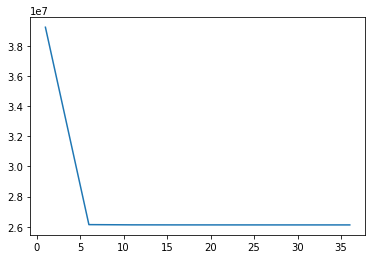

In [228]:
plt.plot(range(1,N_iter + 1,5), loss)

In [229]:
##On calcule le signal y 
y = np.einsum('inm,ijm->ijn', W, x, dtype='complex128') 

In [230]:
t,locuteur1 =  istft(y[:,:,0], fs = rate, nperseg = frame_width_indice, noverlap=noverlap ) #transfo inverse
t,locuteur2 =  istft(y[:,:,1], fs = rate, nperseg = frame_width_indice, noverlap=noverlap ) #transfo inverse
t,locuteur3 =  istft(y[:,:,2], fs = rate, nperseg = frame_width_indice, noverlap=noverlap ) #transfo inverse
t,locuteur4 =  istft(y[:,:,3], fs = rate, nperseg = frame_width_indice, noverlap=noverlap ) #transfo inverse

In [231]:
display(Audio(locuteur1, rate=rate))
display(Audio(locuteur2, rate=rate))
display(Audio(locuteur3, rate=rate))
display(Audio(locuteur4, rate=rate))


In [232]:
#TEST AVEC LES DONNEES MUSICALES


In [233]:
rate, mixture =  wavfile.read("dataset_sample-song_sample-2_mixture_16000.wav")
x = mixture.T
n_channels, T = x.shape
n_sources = n_channels

In [234]:
fft_size, hop_size = 4096, 2048

In [235]:
_, _, X = stft(x, nperseg=fft_size, noverlap=fft_size-hop_size)

In [236]:
X = np.einsum('nij->ijn',X) #on remet l'indice de channel en dernier

In [243]:
##Initialization of parameters for the ICA, IVA
I,J,N = X.shape

W = np.stack([np.eye(N,dtype='complex128')]*I , axis = 0) #W is apriori complex, because it links two complex variables

#comment choisir alpha et beta?? On choisit les paramètres données dans la section IV Expérimentale 
#alpha=beta=0.01
alpha = 0.01
beta = 0.01


N_iter = 40#, #nombre d'itérations données dans le papier pour ICA et IVA

In [245]:
loss = list()
tic = time()
for k in range(N_iter):
    W,R = update_ICA(W,X)
     
    if k%5 == 1: 
        print(f"---------------Step k = {k}---------------")
        Y = np.einsum('inm,ijm->ijn', W, X, dtype='complex128') 
        loss.append(C_etoile(W,R,method='ICA').real)
        print("La fonction de majoration évalué en W et R est :","{:.2e}".format(loss[-1]),"\n\n")
        #on pourrait printer C
   
    
print("\nTemps écoulé", time() - tic, "secondes.")

---------------Step k = 1---------------
La fonction de majoration évalué en W et R est : 1.53e+07 


---------------Step k = 6---------------
La fonction de majoration évalué en W et R est : 1.53e+07 


---------------Step k = 11---------------
La fonction de majoration évalué en W et R est : 1.53e+07 


---------------Step k = 16---------------
La fonction de majoration évalué en W et R est : 1.53e+07 


---------------Step k = 21---------------
La fonction de majoration évalué en W et R est : 1.53e+07 


---------------Step k = 26---------------
La fonction de majoration évalué en W et R est : 1.53e+07 


---------------Step k = 31---------------
La fonction de majoration évalué en W et R est : 1.53e+07 


---------------Step k = 36---------------
La fonction de majoration évalué en W et R est : 1.53e+07 



Temps écoulé 7.012758493423462 secondes.


In [240]:
Y = np.einsum('inm,ijm->nij', W, X, dtype='complex128') 

In [241]:
_, y = istft(Y, nperseg=fft_size, noverlap=fft_size-hop_size)
y = y[:, :T]

In [242]:
for idx in range(n_sources):
    display(Audio(y[idx], rate=rate))

In [ ]:
## Test Sur les Voix

In [269]:
rate, aew_mic3 =  wavfile.read("MNMF\convolved-16000_deg60-mic3.wav")
rate, aew_mic4 =  wavfile.read("MNMF\convolved-16000_deg60-mic4.wav")
rate, axb_mic3 =  wavfile.read("MNMF\convolved-16000_deg300-mic3.wav")
rate, axb_mic4 =  wavfile.read("MNMF\convolved-16000_deg300-mic4.wav")

x_mic3 = aew_mic3 + axb_mic3
x_mic4 = aew_mic4 + axb_mic4

x = np.vstack([x_mic3, x_mic4])
n_channels, T0 = x.shape
n_sources = n_channels


In [270]:
display(Audio(aew_mic3, rate=rate))
display(Audio(axb_mic3, rate=rate))

In [271]:
for idx in range(n_channels):
    display(Audio(x[idx], rate=rate))

In [273]:
_, _, X = stft(x, nperseg=fft_size, noverlap=fft_size-hop_size)
n_channels, n_bins, n_frames = X.shape

In [274]:
X = np.einsum('nij->ijn',X) #on remet l'indice de channel en dernier

In [285]:
##Initialization of parameters for the ICA, IVA
I,J,N = X.shape

W = np.stack([np.eye(N,dtype='complex128')]*I , axis = 0) #W is apriori complex, because it links two complex variables

#comment choisir alpha et beta?? On choisit les paramètres données dans la section IV Expérimentale 
#alpha=beta=0.01
alpha = 0.1
beta = 0.1


N_iter = 40#, #nombre d'itérations données dans le papier pour ICA et IVA

In [286]:
loss = list()
tic = time()
for k in range(N_iter):
    W,R = update_IVA(W,X)
     
    if k%5 == 1: 
        print(f"---------------Step k = {k}---------------")
        Y = np.einsum('inm,ijm->ijn', W, X, dtype='complex128') 
        loss.append(C_etoile(W,R,method='IVA').real)
        print("La fonction de majoration évalué en W et R est :","{:.2e}".format(loss[-1]),"\n\n")
        #on pourrait printer C
   
    
print("\nTemps écoulé", time() - tic, "secondes.")

---------------Step k = 1---------------
La fonction de majoration évalué en W et R est : -1.78e+05 


---------------Step k = 6---------------
La fonction de majoration évalué en W et R est : -2.29e+05 


---------------Step k = 11---------------
La fonction de majoration évalué en W et R est : -2.32e+05 


---------------Step k = 16---------------
La fonction de majoration évalué en W et R est : -2.32e+05 


---------------Step k = 21---------------
La fonction de majoration évalué en W et R est : -2.32e+05 


---------------Step k = 26---------------
La fonction de majoration évalué en W et R est : -2.32e+05 


---------------Step k = 31---------------
La fonction de majoration évalué en W et R est : -2.33e+05 


---------------Step k = 36---------------
La fonction de majoration évalué en W et R est : -2.33e+05 



Temps écoulé 3.312938690185547 secondes.


In [287]:
Y = np.einsum('inm,ijm->nij', W, X, dtype='complex128') 

In [288]:
_, y = istft(Y, nperseg=fft_size, noverlap=fft_size-hop_size)
y = y[:, :T]

In [289]:
for idx in range(n_sources):
    display(Audio(y[idx], rate=rate))

In [384]:
#comment choisir alpha et beta?? On choisit les paramètres données dans la section IV Expérimentale
alpha = 0.01
beta = 0.01

def update(W,x):
    "Cet algo update les W en fonction de l'équation (59), (60) de l'article, x est le mélange"
    I,J,N = x.shape #nombres de bin fréquences, nombre d'indice temporelles, nombre channels
    
    ##Mise à jour de la variable auxiliaire##
    #y = np.zeros((I,J,N),dtype='complex128')
    
    #for i in range(I):
     #   for j in range(J):
      #      y[i,j,:] = W[i,:,:]@x[i,j,:]
            
            
    y = np.einsum('inm,ijm->ijn', W, x, dtype = 'complex128')
    r = np.sqrt( np.sum(abs(y)**2, axis = 0)  )  #r_jn = ||y_jn||_2
    
    #print(y, y_second)
    
    
    
    ##Mise à jour de la variable objective##
    
    ##Calcul de U ##
    ##
    coefficients = 1/(2*beta*np.sqrt(r**2 + alpha) )
    U = np.einsum('jn,ijm,ijl->inml', coefficients, x, np.conj(x), dtype = 'complex128')
    U/=J
    
    ##
    #U = np.zeros((I,N,N,N),dtype='complex128')
    #print(U.shape)
    #for i in range(I):
     #   for n in range(N):
      #      U_in = np.zeros((N,N),dtype='complex128')
            
       #     for j in range(J):
       #         coeff = 1/(2*beta*np.sqrt(r[j,n]**2 + alpha) ) #G'(r_jn)/2r_jn
       #        U_in += coeff*np.outer(x[i,j,:], np.conj(x[i,j,:]) ) 
                
            
       #     U_in /= J
            #print(f"Uin is =" , U_in)
        #    U[i,n,:,:] = U_in
    
    ##Mise à jour de W
    new_W = np.zeros((I,N,N),dtype='complex128')
    for i in range(I):
        for n in range(N):
            e_n = np.zeros(N)
            e_n[n] = 1 
            #e_n est un vecteur de la base canonique de R^N
            #print(W[i,:,:]@U[i,n,:,:])
            w_in = np.linalg.inv(W[i,:,:]@U[i,n,:,:])@e_n  #inverse de W_i@U_in
            #print(np.sqrt(np.conj(w_in.T) @ U[i,n,:,:]@w_in))
            w_in /= np.sqrt(np.conj(w_in.T) @ U[i,n,:,:]@w_in)
            
            
            new_W [i,n,:] = np.conj(w_in) ##new_W est la matrice empilé defini en (55)
            
    return new_W , r #variables objectives et auxilières respectivement